In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
import xray
import pandas as pd
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from datetime import datetime, timedelta
import pytz
import kray #### Custom functions for manipulating xray structures

# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Solargeometry
import solargeo

# OS interaction
import sys
import os

## Directory Lists
# General directories
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_grobs = '/GroundObs'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

# Individual data directories
dir_cv_cimis_ucipm = '/Users/karllapo/gdrive/GroundObs/CA_CentralValley.UCDavis/RAW/CIMIS/UCDavis_IPM.Daily'
dir_cv_cimis = '/Users/karllapo/gdrive/GroundObs/CA_CentralValley.UCDavis/RAW/CIMIS/CIMIS.Hourly'
dir_sio_cdwr = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/GroundObs/YOS.SIO.Obs'

In [14]:
###################
## READ SIO DATA ##
###################
 # Read supporting station information
os.chdir(dir_data+dir_grobs)
stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
stdat = stdat.groupby('Network').get_group('CDWR')

os.chdir(dir_sio_cdwr)
content = os.listdir(os.getcwd())
num_files = len([name for name in os.listdir('.') if os.path.isfile(name)])

# Empty lists and dictionary literals
stations = []
lat = []
lon = []
elev = []
network = []
grobs_yos = {}

# time zone variables
tz_pst = pytz.timezone('US/Pacific')

na_value = ['   NaN']

for files in content:
    # Only read QC formatted files
    if files[-10:] == 'Rad.QC.txt':
        sitename = files.split('.')[0]
        stations.append(sitename)

        # Read SW data, asign to PST, and get SW that passes QC
        grobs_yos[sitename] = pd.read_csv(files,sep= '\t', parse_dates=True, index_col=0, na_values=na_value)
        grobs_yos[sitename].index = grobs_yos[sitename].index.tz_localize(pytz.utc).tz_convert(tz_pst)
        grobs_yos[sitename]['SWdwn_QC'] = grobs_yos[sitename]['SWdwn_Wm^-2'].where(grobs_yos[sitename]['QCFlag'] == 0)

        # New data frame w/ daily means
#         grobs_yos_daily = grobs_yos['SWdwn_Wm^-2'].resample('D', how='mean').to_frame(name='SWdwn_D')
#         grobs_yos_daily['SWdwn_D_QC'] = grobs_yos['SWdwn_QC'].resample('D', how='mean')
#         grobs_yos_daily['SWdwn_D_proc'] = grobs_yos['SWdwn_proc'].resample('D', how='mean')

#         # List containing DataFrames with daily, processed only
#         grobs[sitename] = pd.DataFrame(grobs_yos['SWdwn_D_proc'])
#         grobs[sitename].columns = ['SWdwn']

        # Fill in elevation/lat/lon/network
        elev.append(stdat.loc[sitename]['elevation (m)'])
        lat.append(stdat.loc[sitename]['lat'])
        lon.append(stdat.loc[sitename]['lon'])
        network.append('CDWR')
        
        print(("Processed Site: "+sitename))

Processed Site: bee
Processed Site: dan
Processed Site: dep
Processed Site: for
Processed Site: fsl
Processed Site: gin
Processed Site: gld
Processed Site: hod
Processed Site: lee
Processed Site: mer
Processed Site: olm
Processed Site: oth
Processed Site: piu
Processed Site: pri
Processed Site: smi
Processed Site: smj
Processed Site: stb
Processed Site: sun
Processed Site: vvw


In [39]:
#####################
## convert to xray ##
#####################
# Concatenate 
grobs = pd.concat(grobs_yos,axis=0,keys=stations)
grobs = pd.DataFrame(grobs)

# Convert to xray
grobs = xray.Dataset.from_dataframe(grobs)
grobs = grobs.rename({'level_0':'station','datetime':'time','SWdwn_Wm^-2':'SWdwn_raw'})

# Fill in descriptive variables
grobs.coords['latitude'] = ('station',lat)
grobs.coords['longitude'] = ('station',lon)
grobs.coords['elev'] = ('station',elev)
grobs.coords['network'] = ('station',network)

# Append station classification
os.chdir(dir_data+dir_grobs)
# Station data excel speadsheet
stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
# station data -> xray structure
stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                             'Grouping': (['station'],  stdat.Grouping)})

# Merge into ground observation structure
grobs = grobs.merge(stdat,join='inner')

print(grobs)

<xray.Dataset>
Dimensions:     (station: 19, time: 142831)
Coordinates:
  * station     (station) object 'bee' 'dan' 'dep' 'for' 'fsl' 'gin' 'gld' ...
  * time        (time) datetime64[ns] 2004-08-27T01:30:00 ...
    latitude    (station) float64 37.53 37.9 37.63 37.77 37.48 37.77 37.52 ...
    longitude   (station) float64 118.3 119.3 119.1 119.9 118.4 119.8 118.3 ...
    elev        (station) float64 2.768e+03 2.987e+03 2.307e+03 1.72e+03 ...
    network     (station) |S4 'CDWR' 'CDWR' 'CDWR' 'CDWR' 'CDWR' 'CDWR' ...
    Grouping    (station) object 'east of crest' 'west of crest' ...
Data variables:
    SWdwn_raw   (station, time) float64 nan nan nan nan nan nan nan nan nan ...
    QCFlag      (station, time) float64 nan nan nan nan nan nan nan nan nan ...
    SWdwn_proc  (station, time) float64 nan nan nan nan nan nan nan nan nan ...
    SWdwn_QC    (station, time) float64 nan nan nan nan nan nan nan nan nan ...


In [56]:
#### Elevation Angle
d = pd.to_datetime(grobs.time.values)
el = xray.Dataset()
for stat in grobs.station.values:
    el[stat] = (('time'),solargeo.AVG_EL(d,\
                     grobs.loc[{'station':stat}].latitude.values,\
                     grobs.loc[{'station':stat}].longitude.values,\
                     8,'END'))
el = kray.combinevars(el,el.data_vars,new_dim_name='station',combinevarname='el')
el.coords['time'] = d

# Add to xray Dataset
grobs['el'] = (('station','time'),el)

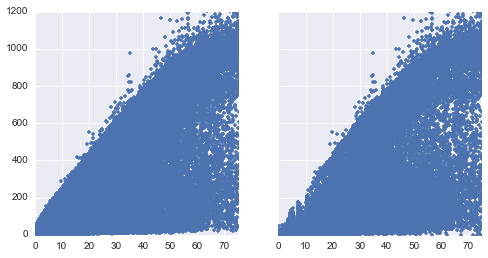

In [66]:
#### Example of raw, QC, and proc at gin flats (known shading)
fig,axes = plt.subplots(1,2,sharey=True,figsize=(8,4))
axes[0].plot(grobs.el.sel(station='gin').values,grobs.SWdwn_proc.sel(station='gin').values,'.')
axes[1].plot(grobs.el.sel(station='gin').values,grobs.SWdwn_raw.sel(station='gin').values,'.')
for ax in axes:
    ax.set_ylim(0,1200)
    ax.set_xlim(0,75)

In [84]:
#### Further refinement:
# Remove the 'smj' station -- excessively bad
grobs = grobs.drop(['smj'],dim='station')

# - remove months with > 10% gaps
# - set 0 daily means to nan
## Resample, exclude months w/ > 10% gaps
grobs_day = grobs.resample(freq='D', dim='time', how='mean')
grobs_day.SWdwn_proc.values[grobs_day.SWdwn_proc.values == 0] = np.nan
numdays_permonth = (~np.isnan(grobs_day['SWdwn_proc']))
print(numdays_permonth)
# .resample(freq='M', dim='time', how='mean')
# grobs_month = grobs_day.resample(freq='M', dim='time', how='mean')
# ds.SWdwn.values[numdays_permonth.values < .9] = np.nan

<xray.DataArray 'SWdwn_proc' (time: 2976, station: 18)>
array([[False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ..., 
       [False, False,  True, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False]], dtype=bool)
Coordinates:
    network    (station) |S4 'CDWR' 'CDWR' 'CDWR' 'CDWR' 'CDWR' 'CDWR' ...
    longitude  (station) float64 118.3 119.3 119.1 119.9 118.4 119.8 118.3 ...
  * station    (station) object 'bee' 'dan' 'dep' 'for' 'fsl' 'gin' 'gld' ...
    elev       (station) float64 2.768e+03 2.987e+03 2.307e+03 1.72e+03 ...
  * time       (time) datetime64[ns] 2004-08-27 2004-08-28 2004-08-29 ...
    latitude   (station) float64 37.53 37.9 37.63 37.77 37.48 37.77 37.52 ...
    Grouping   (station) object 'east of crest' 'west of crest' ...
